# Nullify Image Perspective

## A fun illustration of affine transform and bilinear interpolation

iPython Notebook created by Leland Sun, Dec. 2015

#### Given a photograph taken off-axis of a planar subject, we can reverse the perspective effect of the camera angle and display the subject without the geometric distortions due to perspective.

<table border="0" style="width:80%;border:0px"> <tr style="border:0px">
    <td style="width:50%;border:0px">
        <img src="images/tapestry.jpg" width="200px"/>
    </td>
    <td style="width:50%;border:0px">
        <img src="images/tapestry rectified.jpg" width="265px"/>
    </td>
</tr> </table>

In translating between the 2D coordinates of the image to and from the 2D coordinates of the subject, we need to consider the relationship in 3D space between the camera apparatus and the subject. We are going to employ two 3D coordinate systems that share the same point of origin -- the camera "center". This is the point at which light rays converge in forming the image at the film or digital sensor element.

### The camera basis
Although in actuality the image detection happens behind the camera center, it is simpler to think of the image plane as positioned in front of the camera. The first basis vector of the <em>camera basis</em> goes horizontally from the center of the top-left corner pixel of this virtual sensor element to the center of the pixel on its right. The next basis vector goes vertically from the top-left corner pixel to the pixel below it. The final basis vector goes from the camera center origin to the top-left corner pixel of the virtual sensor element.

### The subject basis
For the subject basis, we first demarcate a rectangular area of interest and decide the dimensions of pixels in which we want this rectangle to be represented. The first basis vector of the <em>subject basis</em> goes horizontally from the center of the top-left corner pixel to the center of the pixel on its right. The next basis vector goes vertically from the top-left corner to the pixel below it. And the final basis vector goes from the camera center origin to the top-left corner pixel of the subject rectangle.

### Overall strategy
Our coordinate translation relies on two transform operations. For any given point on the image plane, we want to transform between its coordinates $(p_0,p_1,p_2)$ in the camera basis and its coordinates $(u_0,u_1,u_2)$ in the subject basis. Change of basis is a matrix-multiplication operation. There exists a matrix $H$ such that 
\\[
\begin{bmatrix} \\ & H & \\ & & \end{bmatrix} 
\begin{bmatrix} p_0 \\ p_1 \\ p_2 \end{bmatrix} = 
\begin{bmatrix} u_0 \\ u_1 \\ u_2 \end{bmatrix}
\\]

We also want to project from the origin through points $u$ on the image plane to points $v$ on the subject plane. That is, each pair of associated $u$ and $v$ points are lined up to the origin. Within the subject basis, this projection is a scaling operation. We know $v_2$ must $=1$, so 
\\[
\begin{bmatrix} v_0 \\ v_1 \\ v_2 \end{bmatrix} = 
\begin{bmatrix} u_0 \\ u_1 \\ u_2 \end{bmatrix} \;\times \displaystyle\frac{1}{\,u_2}
\\]

Because we don't know the values of the camera nor of the subject bases, we would compute $H$ by observing its effect on known points:
\begin{equation}
\begin{bmatrix} 
    \color{Brown}{h_{u0,p0}} & \color{Brown}{h_{u0,p1}} & \color{Brown}{h_{u0,p2}} \\ 
    \color{Brown}{h_{u1,p0}} & \color{Brown}{h_{u1,p1}} & \color{Brown}{h_{u1,p2}} \\ 
    \color{Brown}{h_{u2,p0}} & \color{Brown}{h_{u2,p1}} & \color{Brown}{h_{u2,p2}} 
\end{bmatrix} 
\begin{bmatrix} \color{blue}{p_0} \\ \color{blue}{p_1} \\ 1 \end{bmatrix} = 
\begin{bmatrix} \color{darkgray}{u_0} \\ \color{darkgray}{u_1} \\ \color{darkgray}{u_2} \end{bmatrix} = 
\begin{bmatrix} 
    \color{blue}{v_0}\cdot\color{darkgray}{u_2} \\ \color{blue}{v_1}\cdot\color{darkgray}{u_2} \\ \color{darkgray}{u_2} 
\end{bmatrix} \tag{1} \\
\end{equation}

Although we don't have access to $\color{darkgray}{u_0,u_1,u_2}$, we can observe that certain pixel coordinates $(\color{Blue}{p_0,p_1})$ are mapped to certain subject coordinates $(\color{Blue}{v_0,v_1})$. This implies certain relationships amongst the unknown entries of $\color{Brown}H$ that can be expressed in linear equations in these variables. When we have nine suitable such equations, we can solve the linear system for these nine entries.

Let's see how this is done step by step.

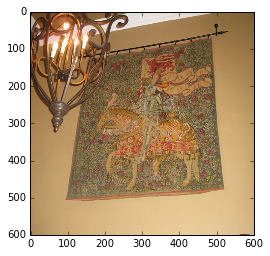

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
I = np.array(plt.imread('images/tapestry.jpg'))

plt.imshow(I)
plt.show()

In this image, the outline of the tapestry constitutes our rectangle of interest. It is known that the tapestry has a 4:5 aspect ratio, so we designate that the rectangle would be represented by 400 pixels across by 500 pixels down. (Because in our color manipulation we only do interpolation and no color blending, we would want the output resolution to be at least as fine as the input.) 

With the help from an image viewer program, we identify the four corners of the tapestry image to be located at pixel coordinates $\color{gray}{(x,y):} \ (151,127)$, $(486,69)$, $(94,506)$, and $(519,478)$ in the camera basis. These four corners correspond to the four points on the subject plane $(0,0)$, $(400,0)$, $(0,500)$, and $(400,500)$ in the subject basis. We thus establish four associations of coordinates between the input image and the rectified representation of the subject.

In [2]:
p_pts = [(151,127), (486,69), (94,506), (519,478)]
v_pts = [(0,0), (400,0), (0,500), (400,500)]

In solving for the change-of-basis matrix $\color{Brown}H$, we would represent each linear equation in the form of a dot product between a vector $\mathbf{w}$ of nine coefficients and the vector $\mathbf{\color{Brown}h}$ of the nine unknown entries of $\color{Brown}H$ to equal a scalar right-hand-side quantity $b$.
\\[ \mathbf{w} \cdot \mathbf{\color{Brown}h} = b \\]

From matrix eq. (1), we can work out two linear equations for each corresponding pair of input and output coordinates:
\begin{align}
    \color{Blue}{p_0} h_{u0,p0} + \color{Blue}{p_1} h_{u0,p1} + h_{u0,p2} 
    - \color{Blue}{v_0}(\color{Blue}{p_0} h_{u2,p0} + \color{Blue}{p_1} h_{u2,p1} + h_{u2,p2}) &= 0 \\ 
    \color{Blue}{p_0} h_{u1,p0} + \color{Blue}{p_1} h_{u1,p1} + h_{u1,p2} 
    - \color{Blue}{v_1}(\color{Blue}{p_0} h_{u2,p0} + \color{Blue}{p_1} h_{u2,p1} + h_{u2,p2}) &= 0
\end{align}

In [3]:
def make_equations(p, v):
    return [[p[0], p[1], 1, 0, 0, 0, -v[0]*p[0], -v[0]*p[1], -v[0]],
    [0, 0, 0, p[0], p[1], 1, -v[1]*p[0], -v[1]*p[1], -v[1]]]

eq_list = []
for (p, v) in zip(p_pts, v_pts):
    eq_list.extend( make_equations(*(p, v)) )
eq_list.append([])

rhs = [0.] * 9
eq_list

[[151, 127, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 151, 127, 1, 0, 0, 0],
 [486, 69, 1, 0, 0, 0, -194400, -27600, -400],
 [0, 0, 0, 486, 69, 1, 0, 0, 0],
 [94, 506, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 94, 506, 1, -47000, -253000, -500],
 [519, 478, 1, 0, 0, 0, -207600, -191200, -400],
 [0, 0, 0, 519, 478, 1, -259500, -239000, -500],
 []]

These coordinate pairings give us eight of the nine needed equations to solve for $\color{Brown}h$. It turns out that they do not resolve the question of scale -- the subject might be very big and far away, or small and close up. It doesn't really matter either way, but in order to pin down <em>some</em> matrix $\color{Brown}H$ that satisfies this correspondence of points, we need to establish some arbitrary scale. We can do so simply by requiring that some entry be equal to 1. This would constitute our ninth linear equation.

In [4]:
eq9 = [0.] * 9
eq9[0] = 1.
eq_list[8] = eq9
rhs[8] = 1.

h = np.linalg.solve(eq_list, rhs)
H = np.matrix( np.reshape(h, (3,3)) )
H

matrix([[  1.00000000e+00,   1.50395778e-01,  -1.70100264e+02],
        [  2.19588398e-01,   1.26831230e+00,  -1.94233510e+02],
        [  3.08478520e-04,   5.52811472e-04,   6.27628060e-01]])

Invoking numpy's solve function with our nine linear equations yields the matrix $H$ for transforming camera coordinates into subject coordinates. We can test it by computing the $u$ points corresponding to our four corner $p$ points. We see that when scaled by $1/u_2$, they agree with the values of our initial $v$ points, within some rounding errors on the order of $10^{-13}$.

In [5]:
u_pts = [(H * np.matrix([p1,p2,1]).transpose()).flatten().tolist()[0] for (p1,p2) in p_pts]
[(u[0] / u[2], u[1] / u[2]) for u in u_pts]

[(3.8179906601812915e-14, 3.8179906601812915e-14),
 (400.0000000000001, 8.710912973680137e-14),
 (0.0, 500.0),
 (400.00000000000006, 500.0000000000001)]

Our change-of-basis matrix works, but what we really want to do is to transform in the reverse direction, from subject coordinates to camera coordinates, so that we can pick out a color for each output pixel using bilinear interpolation of input colors. We'll need to apply the inverse of matrix $H$.

In [6]:
IH = H.getI()
IH

matrix([[  9.82422341e-01,  -2.04907356e-01,   2.02843742e+02],
        [ -2.15032470e-01,   7.39587802e-01,   1.70603677e+02],
        [ -2.93460067e-04,  -5.50713274e-04,   1.34333604e+00]])

However, before we can apply $H^{-1}$, we'll need first to scale each $v$ point by a variable factor $u_2$. Since we already have the $u_2$ values for our reference of four corner $u$ points, we can determine the $u_2$ value for any $v$ point by bilinear interpolation. Because all $u$ points exist on the same plane, this is an exacting operation, and the calculation is also valid for extrapolation beyond the four corners.

In [7]:
def bilinear(x, y, refs):
    '''
    refs is a list of ouput values corresponding to (0,0), (1,0), (0,1), (1,1)
    '''
    return (1-y) * ((1-x) * refs[0] + x * refs[1]) + y * ((1-x) * refs[2] + x * refs[3])

Now we can complete our output-to-input coordinate translation. 

In [8]:
u2_refs = [u[2] for u in u_pts]
op_width = v_pts[3][0]
op_height = v_pts[3][1]

def output_to_input_coord(x, y):
    u2 = bilinear(x / op_width, y / op_height, u2_refs)
    p = IH * np.matrix(np.array([x*u2, y*u2, u2])).transpose()
    return p.item(0), p.item(1)

[output_to_input_coord(*v) for v in v_pts]

[(151.0, 126.99999999999997),
 (485.99999999999994, 68.99999999999997),
 (94.00000000000007, 506.0),
 (518.9999999999999, 477.9999999999999)]

We confirm that our translation function takes our reference $v$ points and comes up with the same coordinates as our original $p$ points (151,127), (486,69), (94,506), and (519,478).

Now we are ready to construct our output image by pinpointing for each output pixel the corresponding spot amongst the input pixels, and then taking a bilinear interpolation of the four immediate neighbor pixels. The interpolation is the very algorithm that we are already using for obtaining the $u_2$ values for arbitrary $v$ points.

In [9]:
def rectify_image(src, origin, size):
    '''
    src: source image
    origin, size: 2-tuples in subject coordinate, specifying the desired extent
    Note: In our coordinate calculations, we use order pair (x, y),
          while indexing is reversed in image arrays: data[y, x]
    '''
    if len(src.shape) < 2 or len(src.shape) > 3:
        raise ValueError('src is not a recognizable image data array')
    if len(origin) != 2 or len(size) != 2:
        raise ValueError('origin and size need to specify (hor, ver) components')

    # Create and initialize a white canvas
    if len(src.shape) == 3:
        output = np.array([[[255] * src.shape[2]] * size[0]] * size[1], dtype = src.dtype)
    else:
        output = np.array([[255] * size[0]] * size[1], dtype = src.dtype)

    for y in range(origin[1], origin[1] + size[1]):
        for x in range(origin[0], origin[0] + size[0]):

            # For each output pixel, find the corresponding input coordinate.
            p = np.array(output_to_input_coord(x, y))
            # If coordinate is within the extent of the input image, ...
            if p[1] >= 0 and p[0] >= 0 and p[1] < src.shape[0] - 1 and p[0] < src.shape[1] - 1:

                NEIGHBORS = [(0,0), (1,0), (0,1), (1,1)]
                p_int = p.astype(int)

                if len(src.shape) == 3:
                    for chan in range(src.shape[2]):
                        refs = [src[p_int[1]+n[1], p_int[0]+n[0], chan] for n in NEIGHBORS]
                        output[y-origin[1], x-origin[0], chan] = bilinear(*(p-p_int), refs)
                else:
                    refs = [src[p_int[1]+n[1], p_int[0]+n[0]] for n in NEIGHBORS]
                    output[y-origin[1], x-origin[0]] = bilinear(*(p-p_int), refs)
    return output

Let's see the result of our work. By controlling the origin and size parameters, we can specify an area independent from our earlier designation of the rectangle of interest in the subject plane. We'll include an extra 50 pixels all the way around the tapestry. (Be mindful that recalculation of the output image may take half a minute for this image size. Take this into consideration, before you get ambitious in transforming images of multi-megapixels.)

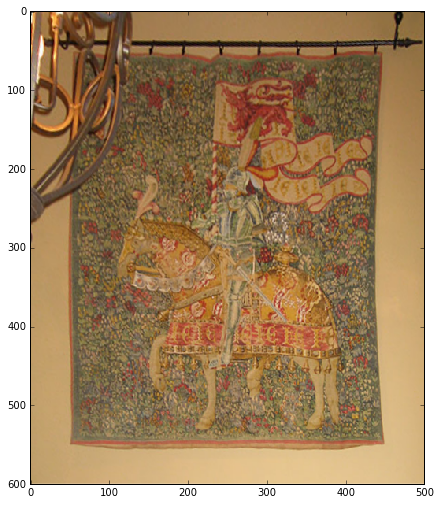

In [10]:
# also works for grayscale images
# G = np.array(plt.imread('images/tapestry-gray.jpg'))

R = rectify_image(I, (-50,-50), (500,600))

dpi = 72
margin = 0.05 # (5% of the width/height of the figure...)
xpixels, ypixels = 500, 600

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

import matplotlib.cm as cm
ax.imshow(R, interpolation='none', cmap = cm.Greys_r)  # cmap ignored for RGB image data
plt.show(fig)

We can also save the result image to file.

In [11]:
fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

ax.imshow(R, interpolation='none', cmap = cm.Greys_r)  # cmap ignored for RGB image data
plt.savefig('images/output.jpg', bbox_inches='tight')
plt.close(fig)

#### Try these codes with your own image data. Just read it into data array, designate its reference p_pts and v_pts, frame your output image, and run all the code cells.